## Ising Model GAN

In [1]:
!wget https://raw.githubusercontent.com/pSzyc/Ising/main/Model/GAN/model.py
!wget https://raw.githubusercontent.com/pSzyc/Ising/main/Model/input_pipeline.py

--2023-12-04 15:08:31--  https://raw.githubusercontent.com/pSzyc/Ising/main/Model/GAN/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2538 (2.5K) [text/plain]
Saving to: ‘model.py.2’

model.py.2          100%[===================>]   2.48K  --.-KB/s    in 0s      

2023-12-04 15:08:31 (38.2 MB/s) - ‘model.py.2’ saved [2538/2538]

--2023-12-04 15:08:31--  https://raw.githubusercontent.com/pSzyc/Ising/main/Model/input_pipeline.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2927 (2.9K) [text/plain]
Saving to: ‘input_pipel

In [2]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import time
from IPython import display
from input_pipeline import dataset_tfrecord_pipeline
from model import make_discriminator_model, make_generator_model, generator_loss, discriminator_loss
import csv
from google.colab import drive
drive.mount('/content/drive')
data_path = "drive/MyDrive/Licencjat"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

In [3]:
trainset_path = f"{data_path}/train.tfrecord"
testset_path =  f"{data_path}/test.tfrecord"
batch_size = 120
train_set = dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
test_set = dataset_tfrecord_pipeline(testset_path, flatten=False, batch_size=batch_size)

Getting data from drive/MyDrive/Licencjat/train.tfrecord
Getting data from drive/MyDrive/Licencjat/test.tfrecord


tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.47738445, shape=(), dtype=float32)


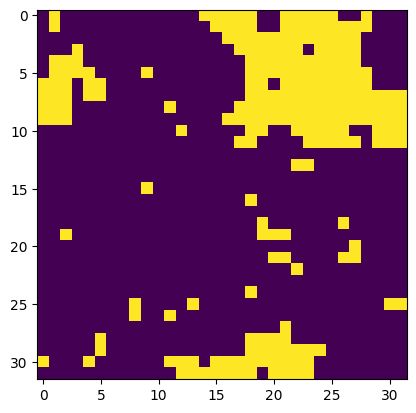

In [4]:
import matplotlib.pyplot as plt

for sample in train_set.take(1):
  plt.imshow(sample[0, :, :, 0])
  print(tf.math.reduce_max(sample))
  print(tf.math.reduce_min(sample))
  print(tf.math.reduce_mean(sample))

## Model

In [5]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [6]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-6)

## Setup training

In [7]:
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 noise_dim])

In [8]:
def train_step(images, gen_loss_log, disc_loss_log):
      noise = tf.random.normal([batch_size, noise_dim])

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(generated_output)
        gen_loss_log.append(gen_loss)
        disc_loss = discriminator_loss(real_output, generated_output)
        disc_loss_log.append(disc_loss)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [9]:
def generate_and_save_images(model, epoch, test_input):
  predictions = tf.round(model(test_input, training=False))

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] > 0.5)
      plt.axis('off')

  plt.savefig(f'{data_path}/Images/image_at_epoch_{epoch}.png')
  plt.show()

In [10]:
def train(dataset, epochs, gen_loss_log, disc_loss_log):

  for epoch in range(epochs):
    start = time.time()

    for images in tqdm(dataset): train_step(images, gen_loss_log, disc_loss_log)

    display.clear_output(wait=True)
    generate_and_save_images(
      generator,
      epoch + 1,
      random_vector_for_generation
    )
    print (f"Time taken for epoch {epoch} is {time.time()- start} sec")

## Train the GAN!

In [11]:
EPOCHS=3
gen_loss_log=[]
disc_loss_log=[]

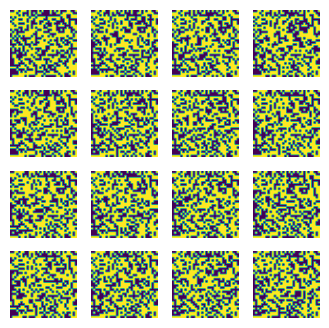

Time taken for epoch 2 is 41.497137784957886 sec
CPU times: user 2min 5s, sys: 3.99 s, total: 2min 9s
Wall time: 2min 25s


In [12]:
%%time
train(train_set, EPOCHS, gen_loss_log, disc_loss_log)

## Plot the loss of the generator and discriminator

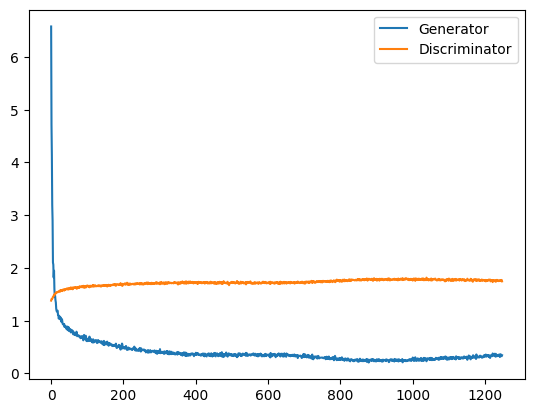

In [13]:
plt.plot(np.asarray(gen_loss_log))
plt.plot(np.asarray(disc_loss_log))
plt.legend(['Generator', 'Discriminator'])

In [14]:
predictions = generator(random_vector_for_generation, training=False)

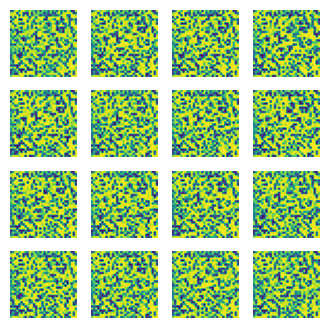

In [18]:
fig = plt.figure(figsize=(4,4))

for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0])
    plt.axis('off')